#### **Import Libraries**

In [228]:
import pandas as pd

#### **Read Train Dataset**

In [254]:
df_train=pd.read_csv('/content/merged_data.csv')
del df_train['Unnamed: 0']
df_train.tail(5)

,id,area_code,outage_duration,broadband_type,outage_type,log_report_type,volume,transit_server_type
48968,14714,area_210,0,broadband_type_2,outage_type_2,log_report_type_232,2,transit_server_type_34
48969,14714,area_210,0,broadband_type_2,outage_type_2,log_report_type_312,3,transit_server_type_35
48970,14714,area_210,0,broadband_type_2,outage_type_2,log_report_type_312,3,transit_server_type_34
48971,6253,area_1007,0,broadband_type_8,outage_type_2,log_report_type_201,6,transit_server_type_15
48972,6253,area_1007,0,broadband_type_8,outage_type_2,log_report_type_80,6,transit_server_type_15


#### **Read Test Dataset**

In [255]:
bd=pd.read_csv('/content/broadband_data.csv')
od=pd.read_csv('/content/outage_data.csv')
rd=pd.read_csv('/content/report_data.csv')
sd=pd.read_csv('/content/server_data.csv')
td=pd.read_csv('/content/test_data.csv')

In [256]:
from functools import reduce
dfs = [td,bd,od,rd,sd]

In [257]:
df_test= reduce(lambda right,left: pd.merge(right,left,on='id'), dfs)

In [258]:
df=df_test.copy()

In [259]:
df_test=df_test.groupby(['id']).agg(lambda x:x.value_counts().index[0])

In [260]:
df_test

,area_code,broadband_type,outage_type,log_report_type,volume,transit_server_type
id,,,,,,
8,area_243,broadband_type_2,outage_type_2,log_report_type_309,3,transit_server_type_34
27,area_793,broadband_type_8,outage_type_1,log_report_type_73,3,transit_server_type_11
53,area_242,broadband_type_2,outage_type_1,log_report_type_134,1,transit_server_type_34
67,area_821,broadband_type_8,outage_type_1,log_report_type_203,2,transit_server_type_11
69,area_875,broadband_type_8,outage_type_1,log_report_type_203,2,transit_server_type_11
...,...,...,...,...,...,...
18467,area_548,broadband_type_8,outage_type_1,log_report_type_55,1,transit_server_type_11
18473,area_1106,broadband_type_8,outage_type_1,log_report_type_54,3,transit_server_type_11
18493,area_700,broadband_type_8,outage_type_2,log_report_type_54,1,transit_server_type_11


In [ ]:
#df_test=df_test.drop_duplicates(subset='id', keep="last")

In [261]:
df_test=df_test.reset_index()
df_test.tail()

,id,area_code,broadband_type,outage_type,log_report_type,volume,transit_server_type
1472,18467,area_548,broadband_type_8,outage_type_1,log_report_type_55,1,transit_server_type_11
1473,18473,area_1106,broadband_type_8,outage_type_1,log_report_type_54,3,transit_server_type_11
1474,18493,area_700,broadband_type_8,outage_type_2,log_report_type_54,1,transit_server_type_11
1475,18537,area_149,broadband_type_2,outage_type_4,log_report_type_313,1,transit_server_type_35
1476,18539,area_147,broadband_type_2,outage_type_1,log_report_type_134,1,transit_server_type_20


####**Concatinate Train and Test set**

In [262]:
final_df=pd.concat([df_train,df_test],axis=0)

In [263]:
final_df=final_df.reset_index()

In [264]:
final_df.tail()

,index,id,area_code,outage_duration,broadband_type,outage_type,log_report_type,volume,transit_server_type
50445,1472,18467,area_548,NaN,broadband_type_8,outage_type_1,log_report_type_55,1,transit_server_type_11
50446,1473,18473,area_1106,NaN,broadband_type_8,outage_type_1,log_report_type_54,3,transit_server_type_11
50447,1474,18493,area_700,NaN,broadband_type_8,outage_type_2,log_report_type_54,1,transit_server_type_11
50448,1475,18537,area_149,NaN,broadband_type_2,outage_type_4,log_report_type_313,1,transit_server_type_35
50449,1476,18539,area_147,NaN,broadband_type_2,outage_type_1,log_report_type_134,1,transit_server_type_20


#### **ONE HOT Encoding**

In [265]:
final_df1=pd.get_dummies(data=final_df, columns=['area_code', 'broadband_type','outage_type','log_report_type','transit_server_type'])

In [266]:
final_df1.tail(2)

,index,id,outage_duration,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,...,transit_server_type_transit_server_type_2,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9
50448,1475,18537,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50449,1476,18539,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### **Train Dataset**

In [267]:
train_set=final_df1.iloc[0:48973,]
del train_set['index']
train_set.tail(3)

,id,outage_duration,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,area_code_area_1035,...,transit_server_type_transit_server_type_2,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9
48970,14714,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48971,6253,0.0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48972,6253,0.0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [268]:
del train_set['id']

#### **Test Dataset**

In [269]:
test_set=final_df1.iloc[48973:]
del test_set['index']
test_set.tail(3)

,id,outage_duration,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,area_code_area_1035,...,transit_server_type_transit_server_type_2,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9
50447,18493,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50448,18537,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50449,18539,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [270]:
test_set.head(2)

,id,outage_duration,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,area_code_area_1035,...,transit_server_type_transit_server_type_2,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9
48973,8,NaN,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48974,27,NaN,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [271]:
del test_set['id']
test_set=test_set.reset_index()

In [273]:
del test_set['index']
test_set.tail()

,outage_duration,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,area_code_area_1035,area_code_area_1036,...,transit_server_type_transit_server_type_2,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9
1472,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1473,NaN,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1474,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1475,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1476,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


####**Outliers Detection**

In [277]:
to_model_columns=train_set.columns
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(train_set[to_model_columns])
pred = clf.predict(train_set[to_model_columns])
train_set['anomaly']=pred
outliers=train_set.loc[train_set['anomaly']==-1]
outlier_index=list(outliers.index)
print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(train_set['anomaly'].value_counts())

[33, 34, 41, 42, 55, 56, 57, 58, 59, 74, 112, 172, 178, 200, 201, 215, 219, 228, 235, 287, 288, 312, 314, 327, 329, 342, 343, 344, 374, 396, 397, 401, 436, 437, 439, 440, 451, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 647, 650, 653, 656, 659, 662, 665, 668, 671, 674, 727, 728, 730, 763, 764, 901, 904, 907, 910, 911, 912, 913, 916, 919, 920, 921, 979, 980, 981, 994, 995, 996, 1046, 1047, 1048, 1052, 1068, 1072, 1088, 1108, 1112, 1131, 1133, 1149, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1171, 1173, 1174, 1176, 1177, 1178, 1181, 1183, 1212, 1213, 1215, 1216, 1217, 1262, 1264, 1333, 1334, 1335, 1336, 1345, 1346, 1349, 1350, 1351, 1352, 1369, 1370, 1371, 1372, 1373, 1375, 1381, 1383, 1384, 1385, 1386, 1387, 1388, 1399, 1400, 1526, 1528, 1529, 1530, 1531, 1538, 1539, 1561, 1579, 1580, 1581, 1586, 1590, 1611, 1612

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#####**Removing Outliers**

In [278]:
train_set1=train_set.drop(train_set.index[[outlier_index]])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:3941: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [279]:
train_set1=train_set1.reset_index()
del train_set1['index']
train_set1.tail()

,outage_duration,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,area_code_area_1035,area_code_area_1036,...,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9,anomaly
43100,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
43101,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
43102,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
43103,0.0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
43104,0.0,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


####**Preparing X and y for training the model**

In [280]:
y=train_set1.outage_duration
X=train_set1.copy()
del X['outage_duration']
del X['anomaly']
X.tail()

,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,area_code_area_1035,area_code_area_1036,area_code_area_1037,...,transit_server_type_transit_server_type_2,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9
43100,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43101,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43102,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43103,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43104,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


####**Train, Validation Split**

In [281]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.35, random_state=5)

####**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train, y_train)
lr_pred=lr.predict(X_val)

In [ ]:
 from sklearn.metrics import accuracy_score
 accuracy_score(y_val, lr_pred)

0.7813577300450809

#####Clasification Report- F1 score, recall, Precision

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(lr_pred,y_val))

              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      9327
         1.0       0.63      0.69      0.65      3534
         2.0       0.70      0.66      0.68      2223

    accuracy                           0.78     15084
   macro avg       0.73      0.73      0.73     15084
weighted avg       0.79      0.78      0.78     15084



In [ ]:
lr.score(X_train,y_train)

0.7996572897329716

#####**Validation Accuracy : 78 %**

#####**Prediction on Test Dataset**

In [ ]:
test_set.head(2)
test_set=test_set.reset_index()

In [ ]:
test_set.tail()

,index,outage_duration,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,area_code_area_1035,...,transit_server_type_transit_server_type_2,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9
12861,61834,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12862,61835,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12863,61836,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12864,61837,NaN,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12865,61838,NaN,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
del test_set['index']
del test_set['outage_duration']

In [ ]:
test_set.head()

,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,area_code_area_1035,area_code_area_1036,area_code_area_1037,...,transit_server_type_transit_server_type_2,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [198]:
prediction_test=lr.predict(test_set)

In [ ]:
prediction_test

array([0., 0., 0., ..., 0., 1., 1.])

#####**Outage Prediction**

In [199]:
outage_prediction=pd.DataFrame(df_test.id)

In [200]:
outage_prediction['Area_code']=df_test.area_code

In [201]:
outage_prediction['Outage_duration_prediction']=prediction_test

In [ ]:
#outage_prediction['broadband_type']=df_test.broadband_type
#outage_prediction['outage_type']=df_test.outage_type
#outage_prediction['log_report_type']=df_test.log_report_type
#outage_prediction['transit_server_type']=df_test.transit_server_type

In [ ]:
outage_prediction.tail(3)

,id,Area_code,Outage_duration_prediction
12863,989,area_38,0.0
12864,3129,area_1067,1.0
12865,3129,area_1067,1.0


In [ ]:
outage_prediction[outage_prediction['id']==989]

,id,Area_code,Outage_duration_prediction
12852,989,area_38,0.0
12853,989,area_38,0.0
12854,989,area_38,0.0
12855,989,area_38,0.0
12856,989,area_38,0.0
12857,989,area_38,0.0
12858,989,area_38,0.0
12859,989,area_38,0.0
12860,989,area_38,0.0
12861,989,area_38,0.0


In [202]:
outage_prediction.Outage_duration_prediction.value_counts()

0.0    7846
1.0    3205
2.0    1815
Name: Outage_duration_prediction, dtype: int64

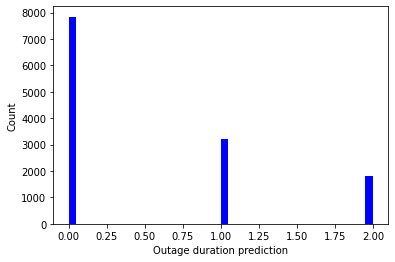

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = outage_prediction.Outage_duration_prediction
num_bins = 40
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=2)
plt.xlabel('Outage duration prediction')
plt.ylabel('Count')
plt.show()

In [203]:
outage_prediction=outage_prediction.sort_values('id')
outage_prediction

,id,Area_code,Outage_duration_prediction
10770,8,area_243,0.0
10768,8,area_243,0.0
10769,8,area_243,0.0
10771,8,area_243,0.0
10772,8,area_243,0.0
...,...,...,...
814,18539,area_147,0.0
815,18539,area_147,0.0
817,18539,area_147,0.0
809,18539,area_147,0.0


In [204]:
outage_prediction=outage_prediction.groupby(['id','Area_code']).agg(lambda x:x.value_counts().index[0])

In [205]:
outage_prediction

,,Outage_duration_prediction
id,Area_code,
8,area_243,0.0
27,area_793,0.0
53,area_242,0.0
67,area_821,1.0
69,area_875,0.0
...,...,...
18467,area_548,0.0
18473,area_1106,1.0
18493,area_700,1.0


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(lr_pred,y_val))

              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      9327
         1.0       0.63      0.69      0.65      3534
         2.0       0.70      0.66      0.68      2223

    accuracy                           0.78     15084
   macro avg       0.73      0.73      0.73     15084
weighted avg       0.79      0.78      0.78     15084



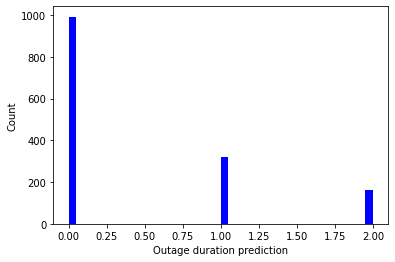

In [206]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = outage_prediction.Outage_duration_prediction
num_bins = 40
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=2)
plt.xlabel('Outage duration prediction')
plt.ylabel('Count')
plt.show()

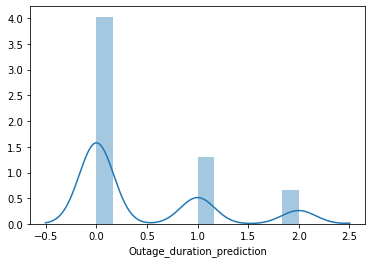

In [207]:
import seaborn as sns
sns.distplot(outage_prediction.Outage_duration_prediction)

#####Outage Duration Prediction.Csv file(Logistic Regresion 78 %)

In [ ]:
outage_prediction.to_csv('outage_duration_prediction.csv')

In [ ]:
outage_prediction.head()

,,Outage_duration_prediction
id,Area_code,
8,area_243,0.0
27,area_793,0.0
53,area_242,0.0
67,area_821,1.0
69,area_875,0.0


####**Adaboost Classifier**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

Adda = AdaBoostClassifier(n_estimators=500, random_state=42)
Adda.fit(X_train, y_train)
pred_Adda=Adda.predict(X_val)
Adda.score(X_val,y_val)


0.749867409175285

##### **Validation Score: 75%**

#####Classification Report F1 score,Recall, Precision

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_Adda,y_val))

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      9507
         1.0       0.54      0.62      0.58      3369
         2.0       0.70      0.67      0.68      2208

    accuracy                           0.75     15084
   macro avg       0.70      0.70      0.70     15084
weighted avg       0.76      0.75      0.75     15084



In [ ]:
prediction_test_Adda=Adda.predict(test_set)

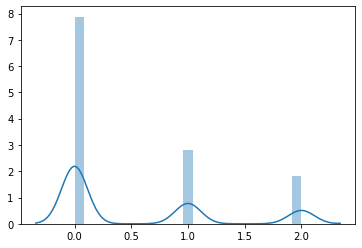

In [ ]:
import seaborn as sns
sns.distplot(pred_Adda)

####**Ridge Classifier**

In [ ]:
from sklearn.linear_model import RidgeClassifier
Ridge = RidgeClassifier().fit(X_train, y_train)
Ridge.score(X_val,y_val)

0.7813577300450809

In [ ]:
pred_Ridge=Ridge.predict(X_val)
Ridge.score(X_train,y_train)

0.798372126231615

In [ ]:
prediction_test_Ridge=Ridge.predict(test_set)

#####**Validation Score: 78 %**

#####Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_Ridge,y_val))

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86      9180
         1.0       0.63      0.68      0.66      3547
         2.0       0.72      0.65      0.68      2357

    accuracy                           0.78     15084
   macro avg       0.74      0.73      0.73     15084
weighted avg       0.78      0.78      0.78     15084



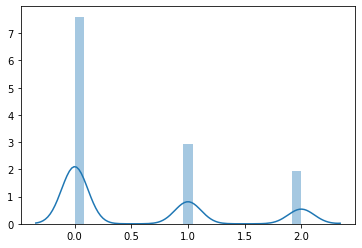

In [ ]:
import seaborn as sns
sns.distplot(pred_Ridge)

####**Random forest classifer**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
Random_Forest = RandomForestClassifier()
Random_Forest.fit(X_train, y_train)
Random_Forest.score(X_val,y_val)

0.7951471758154336

#####**Validation Score : 80%**

In [ ]:
pred_Random_Forest=Ridge.predict(X_val)
Random_Forest.score(X_train,y_train)

0.9518063686991289

In [ ]:
prediction_Test_Random_Forest=Random_Forest.predict(test_set)

#####Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pred_Random_Forest,y_val))

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86      9180
         1.0       0.63      0.68      0.66      3547
         2.0       0.72      0.65      0.68      2357

    accuracy                           0.78     15084
   macro avg       0.74      0.73      0.73     15084
weighted avg       0.78      0.78      0.78     15084



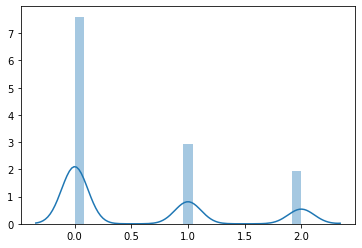

In [ ]:
import seaborn as sns
sns.distplot(pred_Random_Forest)

####**KNN Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
Knn = KNeighborsClassifier(n_neighbors=3) 
Knn.fit(X_train, y_train)
Knn.score(X_val,y_val)

0.7761203924688411

#####**Validation Score : 78%**

####**Decision Tree**

In [282]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
DT= DecisionTreeClassifier(random_state=0)
cross_val_score(DT,X_train,y_train, cv=10)

array([0.81477516, 0.80799429, 0.82155603, 0.81548894, 0.81084939,
       0.82226981, 0.8137045 , 0.8194147 , 0.81256694, 0.81435202])

In [283]:
DT.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [284]:
DT.score(X_val,y_val)

0.8228938821501955

#####**Validation Score : 82%**

In [286]:
pred_DT=DT.predict(X_val)

#####**Classification Report - F1 score,recall, Precision **

In [287]:
from sklearn.metrics import classification_report
print(classification_report(pred_DT,y_val))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88      9444
         1.0       0.71      0.74      0.72      3840
         2.0       0.71      0.78      0.74      1803

    accuracy                           0.82     15087
   macro avg       0.77      0.79      0.78     15087
weighted avg       0.83      0.82      0.82     15087



#####**Prediction on Test Dataset**

In [291]:
del test_set['outage_duration']
test_set

,volume,area_code_area_1,area_code_area_10,area_code_area_100,area_code_area_1000,area_code_area_1002,area_code_area_1005,area_code_area_1006,area_code_area_1007,area_code_area_1008,area_code_area_1009,area_code_area_101,area_code_area_1010,area_code_area_1011,area_code_area_1013,area_code_area_1014,area_code_area_1015,area_code_area_1016,area_code_area_1017,area_code_area_1018,area_code_area_1019,area_code_area_102,area_code_area_1020,area_code_area_1021,area_code_area_1022,area_code_area_1023,area_code_area_1024,area_code_area_1025,area_code_area_1026,area_code_area_1027,area_code_area_1029,area_code_area_103,area_code_area_1030,area_code_area_1031,area_code_area_1032,area_code_area_1033,area_code_area_1034,area_code_area_1035,area_code_area_1036,area_code_area_1037,...,transit_server_type_transit_server_type_2,transit_server_type_transit_server_type_20,transit_server_type_transit_server_type_21,transit_server_type_transit_server_type_22,transit_server_type_transit_server_type_23,transit_server_type_transit_server_type_24,transit_server_type_transit_server_type_25,transit_server_type_transit_server_type_26,transit_server_type_transit_server_type_27,transit_server_type_transit_server_type_28,transit_server_type_transit_server_type_29,transit_server_type_transit_server_type_3,transit_server_type_transit_server_type_30,transit_server_type_transit_server_type_31,transit_server_type_transit_server_type_32,transit_server_type_transit_server_type_34,transit_server_type_transit_server_type_35,transit_server_type_transit_server_type_36,transit_server_type_transit_server_type_37,transit_server_type_transit_server_type_38,transit_server_type_transit_server_type_39,transit_server_type_transit_server_type_40,transit_server_type_transit_server_type_41,transit_server_type_transit_server_type_42,transit_server_type_transit_server_type_43,transit_server_type_transit_server_type_44,transit_server_type_transit_server_type_45,transit_server_type_transit_server_type_46,transit_server_type_transit_server_type_47,transit_server_type_transit_server_type_48,transit_server_type_transit_server_type_49,transit_server_type_transit_server_type_5,transit_server_type_transit_server_type_50,transit_server_type_transit_server_type_51,transit_server_type_transit_server_type_53,transit_server_type_transit_server_type_54,transit_server_type_transit_server_type_6,transit_server_type_transit_server_type_7,transit_server_type_transit_server_type_8,transit_server_type_transit_server_type_9
0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1473,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1474,1,0

In [292]:
prediction_test_DT=DT.predict(test_set)

#####**Outage Prediction**

In [293]:
outage_prediction=pd.DataFrame(df_test.id)

In [294]:
outage_prediction['Area_code']=df_test.area_code
outage_prediction['Outage_duration_prediction']=prediction_test_DT

In [295]:
outage_prediction=outage_prediction.sort_values('id')
outage_prediction

,id,Area_code,Outage_duration_prediction
0,8,area_243,0.0
1,27,area_793,0.0
2,53,area_242,0.0
3,67,area_821,0.0
4,69,area_875,1.0
...,...,...,...
1472,18467,area_548,0.0
1473,18473,area_1106,1.0
1474,18493,area_700,0.0
1475,18537,area_149,0.0


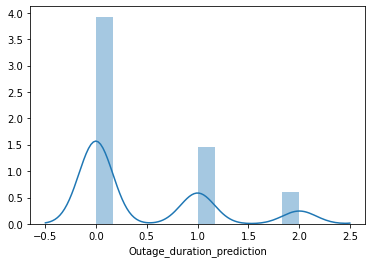

In [296]:
import seaborn as sns
sns.distplot(outage_prediction['Outage_duration_prediction'])

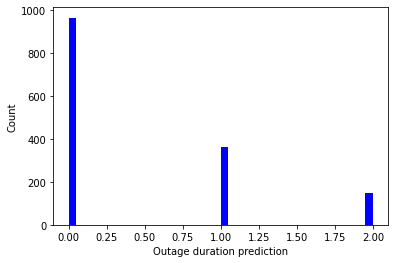

In [297]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = outage_prediction.Outage_duration_prediction
num_bins = 40
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=2)
plt.xlabel('Outage duration prediction')
plt.ylabel('Count')
plt.show()

#####**Outage Duration Prediction Csv file (Decision Tree 82% Accuracy)**

In [298]:
outage_prediction.to_csv('outage_duration_prediction_DT.csv')